<a href="https://colab.research.google.com/github/rsidorchuk93/bots/blob/main/gmail_api_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gmail script which reads emails, classifies them (via API call to Open AI GPT), and creates draft replies

**Purpose example**: automate interviews scheduling

**Gmail access settings prerequisites (takes ~5 min):**
1. Create a new project in the Google Developers Console:
   1. Go to https://console.developers.google.com/ and sign in with your Google account.
   2. Click on "Select a project" at the top right corner, and then click on the "New Project" button.
   2. Enter a project name, select a billing account (if applicable), and click "Create."

2.  Enable the Gmail API:
   1. In the Google Developers Console, go to the "Dashboard" and click on "+ ENABLE APIS AND SERVICES" at the top.
   2. Search for "Gmail API" and click on the result.
   3. Click "ENABLE" to enable the Gmail API for your project.

3.  Create credentials:
   1. In the Gmail API page, click "Create credentials" at the top.
   2. Choose "Gmail API" for "Which API are you using?" and "Other non-UI (e.g., cron job, daemon)" for "Where will you be calling the API from?"
   3. Select "User data" for "What data will you be accessing?" and click "Next."
   4. Choose a name for the OAuth 2.0 client ID, select your email address for the "User support email," and click "Create."
   5. Download the JSON file containing your client credentials by clicking "Download" and save it in your project directory. Rename the file to "credentials.json."

4.  Add your own email as a test user

In [1]:
# installing libraries
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib openai beautifulsoup4 -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.7 MB/s eta 0:00:00


In [2]:
# Upload the "credentials.json" file to the Colab environment
from google.colab import files
uploaded = files.upload()

Saving credentials.json to credentials.json


In [ ]:
# Run the authentication code in the Colab notebook. After that click the link to authorize access of this script to your email 
import os
import pickle
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import Flow

SCOPES = ['https://www.googleapis.com/auth/gmail.readonly', 
          'https://www.googleapis.com/auth/gmail.send',
          'https://www.googleapis.com/auth/gmail.compose']

def get_credentials():
    creds = None

    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = Flow.from_client_secrets_file('credentials.json', SCOPES)
            flow.redirect_uri = 'urn:ietf:wg:oauth:2.0:oob'
            auth_url, _ = flow.authorization_url(prompt='consent')
            print('Please go to this URL and authorize the app:', auth_url)
            auth_code = input('Enter the authorization code: ')
            flow.fetch_token(code=auth_code)
            creds = flow.credentials

        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return creds

creds = get_credentials()
print("Authentication successful!")

In [4]:
import openai
import os

openai.api_key = "XXX"

def is_job_interview_invitation(text):
    prompt = f"Is the following text a job interview invitation? Please answer 'Yes' or 'No'.\n\n{text}\n\nAnswer: "
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=prompt,
        max_tokens=10,
        n=1,
        stop=None,
        temperature=0.5,
    )

    answer = response.choices[0].text.strip()
    return answer.lower() == "yes"

In [14]:
import re
import base64
import urllib.parse
from googleapiclient.discovery import build
from bs4 import BeautifulSoup
from email.mime.text import MIMEText

def get_sender_and_date(headers):
    sender = ''
    sent_date = ''
    for header in headers:
        name = header['name']
        if name == 'From' or name == 'from':
            sender = header['value']
        elif name == 'Date' or name == 'date':
            sent_date = header['value']
    return sender, sent_date

def extract_forwarded_messages(body):
    forwarded_message_regex = r"[-]+ Forwarded message [-]+\nFrom: (.*?)\nDate: (.*?)\nSubject: (.*?)\nTo: (.*?)\n\n(.*?)(?=\n[-]+ Forwarded message [-]+|\Z)"
    forwarded_messages = re.findall(forwarded_message_regex, body, re.DOTALL)
    return forwarded_messages

def extract_hyperlinks(text):
    return re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)

def remove_extra_whitespaces(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    cleantext = soup.get_text()
    
    # Remove extra whitespaces
    cleantext = re.sub(r'\s+', ' ', cleantext).strip()
    return cleantext

def get_last_n_emails(n):
    service = build('gmail', 'v1', credentials=creds)

    # Get a list of messages in the inbox
    result = service.users().messages().list(userId='me', labelIds=['INBOX'], maxResults=n).execute()
    messages = result.get('messages', [])

    if not messages:
        print('No messages found.')
    else:
        for message in messages:
            msg_id = message['id']
            msg = service.users().messages().get(userId='me', id=msg_id).execute()

            # Extract the email subject and body
            payload = msg['payload']
            headers = payload['headers']
            subject = ''
            body = ''

            for header in headers:
                name = header['name']
                if name == 'subject' or name == 'Subject':
                    subject = header['value']

            if 'parts' in payload:
                parts = payload['parts']
                for part in parts:
                    filename = part.get('filename')
                    mimeType = part.get('mimeType')
                    if mimeType == 'text/plain' or mimeType == 'text/html':
                        body = part.get('body').get('data')
                        break
            else:
                body = payload.get('body').get('data')

            # Decode the base64url encoded email body
            body = base64.urlsafe_b64decode(urllib.parse.unquote(body)).decode('utf-8')

            # Extract hyperlinks from the email body
            hyperlinks = extract_hyperlinks(body)

            # Remove hyperlinks from the body
            for link in hyperlinks:
                body = body.replace(link, '')

            # Remove extra whitespaces
            body = remove_extra_whitespaces(body)

            sender, sent_date = get_sender_and_date(headers)

            forwarded_messages = extract_forwarded_messages(body)
            if forwarded_messages:
                for fm_sender, fm_date, fm_subject, fm_to, fm_body in forwarded_messages:
                    fm_body = remove_extra_whitespaces(fm_body.strip())
                    print("From:", fm_sender)
                    print("Sent:", fm_date)
                    print("Subject:", fm_subject)
                    print("Body:", fm_body)
                    print("---------")
            else:
                body = remove_extra_whitespaces(body.strip())
                print("From:", sender)
                print("Sent:", sent_date)
                print("Subject:", subject)
                print("Body:", body)
                if hyperlinks:
                    print("Hyperlinks:", ', '.join(hyperlinks))
                
                # Check if the email is a job interview invitation
                is_invitation = is_job_interview_invitation(f"{subject}\n{body}")

                if is_invitation:
                    print("This email is a job interview invitation.")
                    
                    # Extract first name from sender's email
                    first_name = sender.split()[0]

                    # Construct the reply message
                    message = MIMEText(f"Dear {first_name},\n\nSee below my availability in Eastern time zone: Anytime from 11 am")
                    message['to'] = sender
                    message['subject'] = 'Availability for Job Interview'
                    message['In-Reply-To'] = msg_id
                    message['References'] = msg_id

                    # Create a draft reply with the original message threadId
                    thread_id = msg['threadId']
                    create_message = {'message': {'raw': base64.urlsafe_b64encode(message.as_bytes()).decode(), 'threadId': thread_id}}
                    draft = service.users().drafts().create(userId='me', body=create_message).execute()

                    print("A draft reply email has been created.\n")
                else:
                    print("This email is not a job interview invitation.\n")

# Example usage: Print the last 5 emails
get_last_n_emails(5)

From: Roman Sidorchuk <sidorchukrr@gmail.com>
Sent: Thu, 13 Apr 2023 00:01:44 -0400
Subject: Company B - schedule an interview
Body: Hi Roman, I hope you've been having a great week! Thank you for taking the time to meet with xx, he enjoyed getting to know you! I'm excited to reach out to schedule your next interview with xx and xx on the team. If you could just send me a couple of times that work for you this week and late next week, I can use those to find an open window for them and get something on the calendar. As soon as I do, you'll receive a calendar invitation from me with the Zoom details! If you have any questions, you can let me know. We look forward to chatting more with you! Regards, xx, People Operations Partner
This email is a job interview invitation.
A draft reply email has been created.

From: Roman Sidorchuk <sidorchukrr@gmail.com>
Sent: Thu, 13 Apr 2023 00:00:40 -0400
Subject: AI company follow up
Body: Hi Roman, I received your resume from xx here at xx and wanted

**Bot read my emails, correctly classified them, and created draft replies with my availability** 

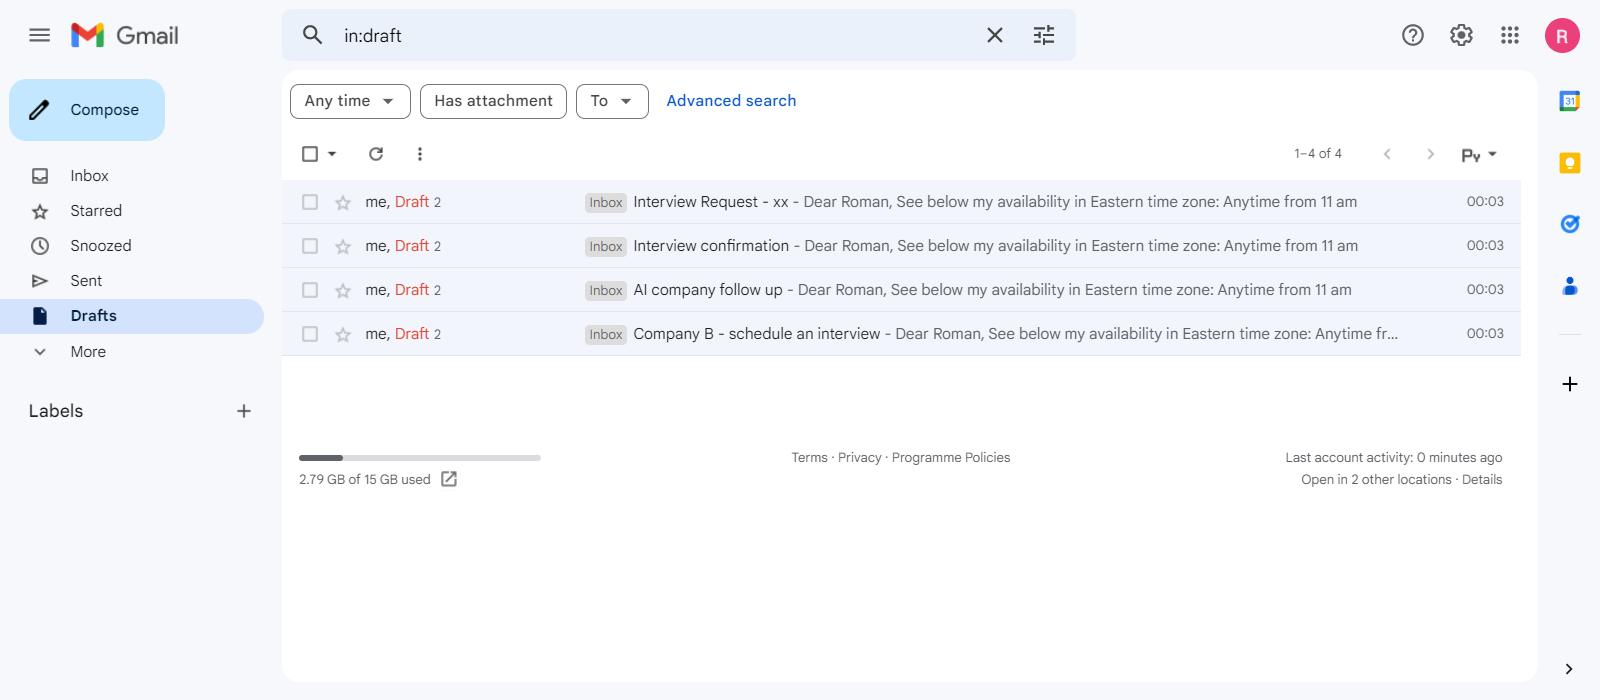

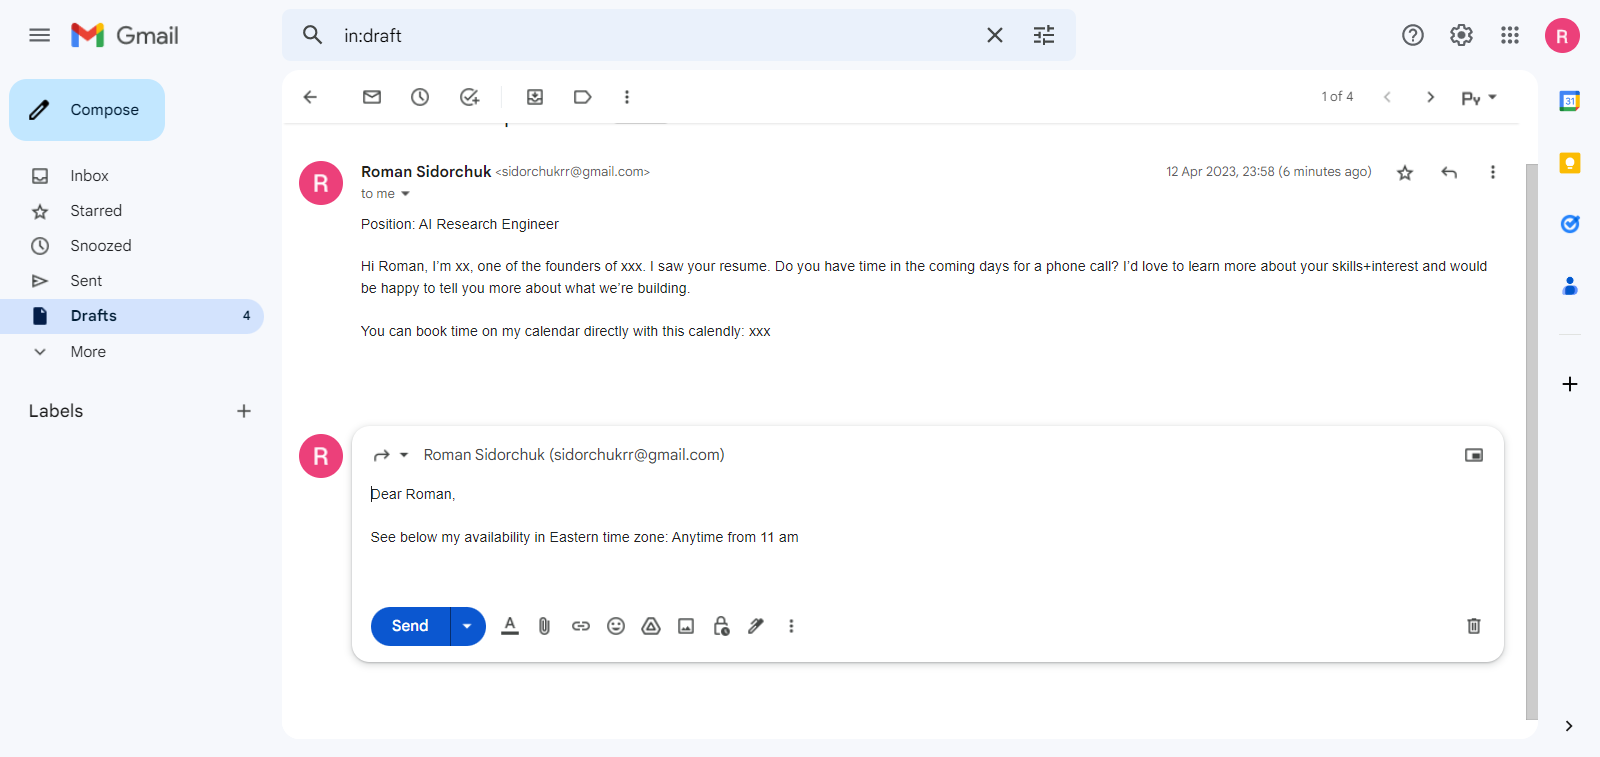